# Modèle de prédiction d'une réponse binaire à partir des réponses aux questions ouvertes

In [3]:
import tensorflow as tf
import csv, sys
%env TF_FORCE_GPU_ALLOW_GROWTH=true
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import TextVectorization
from keras.optimizers import Adam
from keras_tuner import HyperParameters, RandomSearch

env: TF_FORCE_GPU_ALLOW_GROWTH=true


# Récupération et préparation des données 

In [6]:
# taille du CSV trop importante
csv.field_size_limit(sys.maxsize)

with open("../donnees/LA_TRANSITION_ECOLOGIQUE.csv") as f:
    reader = csv.reader(f)
    header = next(reader)
    label = []
    text = []
    # on garde seulement les lignes contenant des réponses à toutes les questions 
    for row in reader:
        # on stocke les colonnes contenant les questions ouvertes dans une string (strings concaténées avec espace) et les labels dans une liste
        if row[12] != '' and  row[17] != '' and  row[18] != '' and row[24] != '' and row[25] != '' and row[26] != '' and row[13] != '': 
            text.append(row[12] + " "+ row[17] + " "+ row[18] + " "+ row[24] + " "+ row[25]  + " "+ row[26]  ), label.append(row[13])

print(len(text))

62240


In [7]:
text_vectorizer = TextVectorization(max_tokens=1000,
                                            output_sequence_length=1000,
                                            standardize='lower_and_strip_punctuation',
                                            split='whitespace',
                                            output_mode='int')

In [8]:
text_vectorizer.adapt(text)

2023-05-20 20:04:29.399818: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [9]:
text_vectorizer.get_vocabulary()[:20]

['',
 '[UNK]',
 'de',
 'les',
 'et',
 'des',
 'la',
 'le',
 'à',
 'en',
 'pour',
 'que',
 'pas',
 'qui',
 'plus',
 'une',
 'un',
 'sur',
 'dans',
 'par']

In [10]:
X_traindev_raw, X_test_raw, Y_traindev_raw, Y_test_raw = train_test_split(text, label, train_size=0.8, shuffle=False)
X_train_raw, X_dev_raw, Y_train_raw, Y_dev_raw = train_test_split(X_traindev_raw, Y_traindev_raw, train_size=0.8, shuffle=False)

In [11]:
# encodage des labels binaires et transformation des données en array
dico_labels = {"Non": 0, "Oui": 1}

training_data = np.array(X_train_raw)
training_labels = np.array([dico_labels[d] for d in Y_train_raw])

dev_data = np.array(X_dev_raw)
dev_labels = np.array([dico_labels[d] for d in Y_dev_raw])

testing_data = np.array(X_test_raw)
testing_labels = np.array([dico_labels[d] for d in Y_test_raw])

In [12]:
# vectorisation des données d'entraînement, de validation et de test
X_train_ok = text_vectorizer(training_data)
X_dev_ok = text_vectorizer(dev_data)
X_test_ok = text_vectorizer(testing_data)
print(X_train_ok.shape, X_dev_ok.shape, X_test_ok.shape)

(39833, 1000) (9959, 1000) (12448, 1000)


# Construction du modèle

## Sans Tuning

In [13]:
def build_model(tv): 
      inputs = keras.layers.Input(shape=(tv.vocabulary_size(),))
      embeddings = keras.layers.Embedding(input_dim=tv.vocabulary_size(),
                                        output_dim=64,
                                        name='emb'
                                       )(inputs)
      pooling = keras.layers.GlobalAveragePooling1D()(embeddings)
      dropout = keras.layers.Dropout(0.5)(pooling)
      dense1 = keras.layers.Dense(10, activation="relu", use_bias=True)(dropout)
      dropout2 = keras.layers.Dropout(0.5)(dense1)    
      dense = keras.layers.Dense(1, activation="sigmoid", use_bias=True)(dropout2)
      model = keras.Model(inputs=inputs, outputs=dense)
      model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=["accuracy"])
      return model

In [14]:
model_sans_tuning = build_model(text_vectorizer)

In [15]:
model_sans_tuning.fit(x=X_train_ok, y=training_labels, epochs=50, batch_size=32, validation_data=(X_dev_ok, dev_labels), verbose=1)

Epoch 1/50
1245/1245 [==============================] - 5s 4ms/step - loss: 0.5933 - accuracy: 0.7296 - val_loss: 0.5427 - val_accuracy: 0.7660
Epoch 2/50
1245/1245 [==============================] - 5s 4ms/step - loss: 0.5788 - accuracy: 0.7306 - val_loss: 0.5391 - val_accuracy: 0.7660
Epoch 3/50
1245/1245 [==============================] - 5s 4ms/step - loss: 0.5694 - accuracy: 0.7306 - val_loss: 0.5262 - val_accuracy: 0.7660
Epoch 4/50
1245/1245 [==============================] - 5s 4ms/step - loss: 0.5616 - accuracy: 0.7309 - val_loss: 0.5225 - val_accuracy: 0.7663
Epoch 5/50
1245/1245 [==============================] - 5s 4ms/step - loss: 0.5575 - accuracy: 0.7319 - val_loss: 0.5172 - val_accuracy: 0.7664
Epoch 6/50
1245/1245 [==============================] - 5s 4ms/step - loss: 0.5536 - accuracy: 0.7321 - val_loss: 0.5157 - val_accuracy: 0.7665
Epoch 7/50
1245/1245 [==============================] - 5s 4ms/step - loss: 0.5520 - accuracy: 0.7327 - val_loss: 0.5191 - val_accuracy:

In [16]:
score = model_sans_tuning.evaluate(X_test_ok, testing_labels )

print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

389/389 [==============================] - 1s 1ms/step - loss: 0.4962 - accuracy: 0.7909
Test loss: 0.49624398350715637
Test accuracy: 0.790890097618103


## Visualisation des données et résultats du modèle 1

389/389 [==============================] - 1s 1ms/step


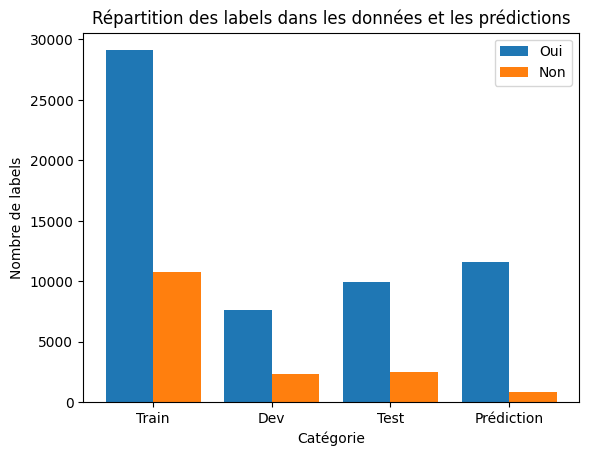

In [24]:
import numpy as np 
import matplotlib.pyplot as plt 
  
pred = model_sans_tuning.predict(X_test_ok)

oui_pred = [predict for predict in pred if predict >= 0.5]
non_pred = [predict for predict in pred if predict < 0.5 ]


oui_train = [ele for ele in training_labels if ele==1]
non_train = [ele for ele in training_labels if ele==0]

oui_dev = [ele for ele in dev_labels if ele==1]
non_dev = [ele for ele in dev_labels if ele==0]

oui_test = [ele for ele in testing_labels if ele==1]
non_test = [ele for ele in testing_labels if ele==0]

oui = [len(oui_train), len(oui_dev), len(oui_test), len(oui_pred)]
non = [len(non_train), len(non_dev), len(non_test), len(non_pred)]

X = ['Train', 'Dev', 'Test', 'Prédiction']

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, oui, 0.4, label = 'Oui')
plt.bar(X_axis + 0.2, non, 0.4, label = 'Non')
  
plt.xticks(X_axis, X)
plt.xlabel("Catégorie")
plt.ylabel("Nombre de labels")
plt.title("Répartition des labels dans les données et les prédictions")
plt.legend()
plt.show()

389/389 [==============================] - 1s 1ms/step


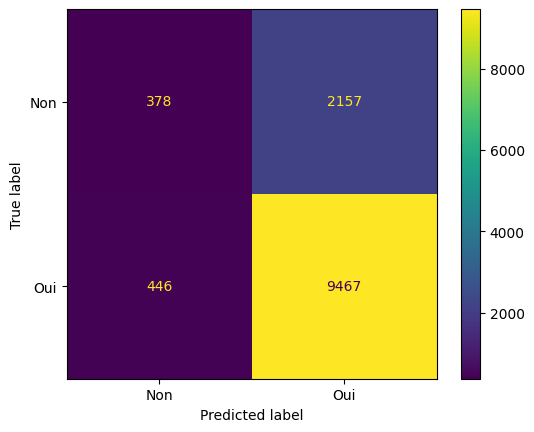

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Y_output = model_sans_tuning.predict(X_test_ok)
Y_prediction = [0 if ele < 0.5 else 1 for ele in Y_output]
cm = confusion_matrix(testing_labels, Y_prediction)
ConfusionMatrixDisplay(cm, display_labels=["Non", "Oui"]).plot()

## Avec Tuning

In [87]:
def build_model(tv, emb_size, learning_rate, dropout_rate):
      inputs = keras.layers.Input(shape=(tv.vocabulary_size(),))
      embeddings = keras.layers.Embedding(input_dim=tv.vocabulary_size(),
                                        output_dim=emb_size,
                                        name='emb'
                                       )(inputs)
      pooling = keras.layers.GlobalAveragePooling1D()(embeddings)
      dropout = keras.layers.Dropout(dropout_rate)(pooling)
      dense1 = keras.layers.Dense(10, activation="relu", use_bias=True)(dropout)
      dropout2 = keras.layers.Dropout(dropout_rate)(dense1)    
      dense = keras.layers.Dense(1, activation="sigmoid", use_bias=True)(dropout2)
      model = keras.Model(inputs=inputs, outputs=dense)
      model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=["accuracy"])
      return model

In [88]:
def hypermodel(hp: HyperParameters)-> keras.Model:
    lr = hp.Float("learning_rate", min_value=0.001,
                  max_value=0.1,
                  #step=5,
                  sampling='log')
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, 
                            max_value=0.9, step=0.1)
    emb_size = hp.Int('emb_size', min_value=50, 
                      max_value=1000, 
                      step=5)
    return build_model(text_vectorizer, emb_size=emb_size, learning_rate=lr, dropout_rate = dropout_rate)

In [95]:
tuner = RandomSearch(
    hypermodel=hypermodel,
    objective='val_accuracy',
    max_trials=5,
    project_name='tuner_prediction_simple')

In [96]:
tuner.search(X_train_ok, training_labels, shuffle=False, 
             validation_data=(X_dev_ok, dev_labels),
             epochs=10)

Trial 5 Complete [00h 01m 14s]
val_accuracy: 0.7660407423973083

Best val_accuracy So Far: 0.7663419842720032
Total elapsed time: 00h 14m 47s
INFO:tensorflow:Oracle triggered exit


In [91]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
emb_size (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 5, 'sampling': None}


In [97]:
tuner.results_summary()

Results summary
Results in ./tuner_prediction_simple
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.005389330566596739
dropout_rate: 0.6
emb_size: 230
Score: 0.7663419842720032
Trial summary
Hyperparameters:
learning_rate: 0.016993429801653186
dropout_rate: 0.2
emb_size: 765
Score: 0.7660407423973083
Trial summary
Hyperparameters:
learning_rate: 0.023826312221041396
dropout_rate: 0.8
emb_size: 655
Score: 0.7660407423973083
Trial summary
Hyperparameters:
learning_rate: 0.03019785947411054
dropout_rate: 0.2
emb_size: 175
Score: 0.7660407423973083
Trial summary
Hyperparameters:
learning_rate: 0.07554273099394239
dropout_rate: 0.30000000000000004
emb_size: 155
Score: 0.7660407423973083


In [98]:
best_model = tuner.get_best_models(1)[0]

In [99]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 emb (Embedding)             (None, 1000, 230)         230000    
                                                                 
 global_average_pooling1d (G  (None, 230)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 230)               0         
                                                                 
 dense (Dense)               (None, 10)                2310      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                             

In [100]:
best_model.fit(x=X_train_ok, y=training_labels, epochs=50, batch_size=32, validation_data=(X_dev_ok, dev_labels), verbose=1)

Epoch 1/50
1245/1245 [==============================] - 11s 9ms/step - loss: 0.5560 - accuracy: 0.7325 - val_loss: 0.5260 - val_accuracy: 0.7669
Epoch 2/50
1245/1245 [==============================] - 11s 9ms/step - loss: 0.5559 - accuracy: 0.7326 - val_loss: 0.5176 - val_accuracy: 0.7664
Epoch 3/50
1245/1245 [==============================] - 11s 9ms/step - loss: 0.5543 - accuracy: 0.7340 - val_loss: 0.5228 - val_accuracy: 0.7662
Epoch 4/50
1245/1245 [==============================] - 11s 9ms/step - loss: 0.5536 - accuracy: 0.7332 - val_loss: 0.5170 - val_accuracy: 0.7670
Epoch 5/50
1245/1245 [==============================] - 11s 9ms/step - loss: 0.5533 - accuracy: 0.7335 - val_loss: 0.5178 - val_accuracy: 0.7678
Epoch 6/50
1245/1245 [==============================] - 11s 9ms/step - loss: 0.5540 - accuracy: 0.7337 - val_loss: 0.5192 - val_accuracy: 0.7662
Epoch 7/50
1245/1245 [==============================] - 11s 9ms/step - loss: 0.5523 - accuracy: 0.7336 - val_loss: 0.5213 - val_ac

In [101]:
best_score = best_model.evaluate(X_test_ok, testing_labels )

print(f"Test loss: {best_score[0]}")
print(f"Test accuracy: {best_score[1]}")

389/389 [==============================] - 1s 4ms/step - loss: 0.5000 - accuracy: 0.7977
Test loss: 0.49995437264442444
Test accuracy: 0.7977185249328613


In [105]:
pred = best_model.predict(X_test_ok)

389/389 [==============================] - 1s 3ms/step


# Visualisation des données et des prédictions du meilleur modèle

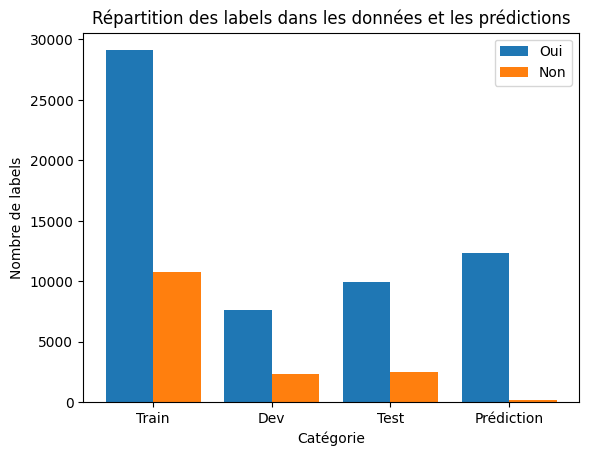

In [122]:
import numpy as np 
import matplotlib.pyplot as plt 
  
oui_pred = [predict for predict in pred if predict > 0.5]
non_pred = [predict for predict in pred if predict < 0.5 ]


oui_train = [ele for ele in training_labels if ele==1]
non_train = [ele for ele in training_labels if ele==0]

oui_dev = [ele for ele in dev_labels if ele==1]
non_dev = [ele for ele in dev_labels if ele==0]

oui_test = [ele for ele in testing_labels if ele==1]
non_test = [ele for ele in testing_labels if ele==0]

oui = [len(oui_train), len(oui_dev), len(oui_test), len(oui_pred)]
non = [len(non_train), len(non_dev), len(non_test), len(non_pred)]

X = ['Train', 'Dev', 'Test', 'Prédiction']

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, oui, 0.4, label = 'Oui')
plt.bar(X_axis + 0.2, non, 0.4, label = 'Non')
  
plt.xticks(X_axis, X)
plt.xlabel("Catégorie")
plt.ylabel("Nombre de labels")
plt.title("Répartition des labels dans les données et les prédictions")
plt.legend()
plt.show()